In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten,Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import layers

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

%matplotlib inline


In [23]:
prod_cat_data = pd.read_csv('C:/Users/Derya/Downloads/ecommerce.csv')
prod_cat_data.shape

(20000, 15)

In [24]:
prod_cat_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [26]:
prod_cat_data['product_category_tree'].value_counts()

["Jewellery >> Necklaces & Chains >> Necklaces"]                                                                                                                1567
["Jewellery >> Rings"]                                                                                                                                           710
["Automotive >> Accessories & Spare parts >> Car Interior & Exterior >> Car Interior >> Car Mats"]                                                               522
["Jewellery >> Bangles, Bracelets & Armlets >> Bangles"]                                                                                                         430
["Tools & Hardware >> Tools >> Gardening Tools >> Plant Containers & Sets >> Plant Container Sets"]                                                              332
                                                                                                                                                                ... 
["Clothing

In [34]:
fig, ax = plt.subplots(figsize=[8,4], nrows=1, ncols=1)
prod_cat_data['product_category_tree'].value_counts().plot(ax=ax,kind='bar', title='Product Category Distribution')

In [29]:
missing = pd.DataFrame(prod_cat_data.isnull().sum()).rename(columns = {0: 'missing'})

In [30]:
missing['percent'] = missing['missing'] / len(prod_cat_data)

In [31]:
missing.sort_values('percent', ascending = False)

,missing,percent
brand,5864,0.29320
retail_price,78,0.00390
discounted_price,78,0.00390
product_specifications,14,0.00070
image,3,0.00015
description,2,0.00010
uniq_id,0,0.00000
crawl_timestamp,0,0.00000
product_url,0,0.00000
product_name,0,0.00000


In [35]:
prod_cat_data=prod_cat_data[pd.notnull(prod_cat_data['description'])]

Text(0.5, 1.0, 'Word distribution per bin')

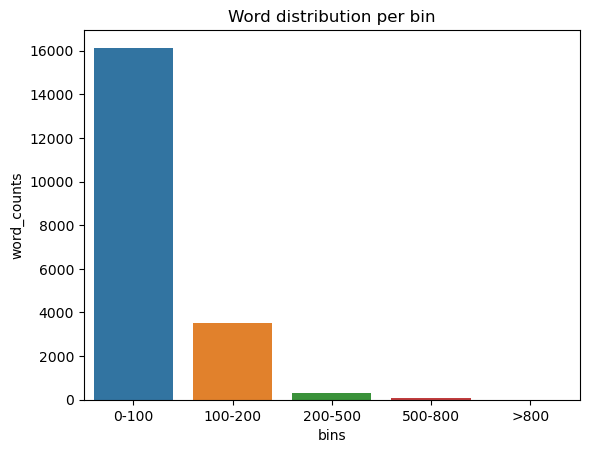

In [38]:
prod_cat_data['no_of_words'] = prod_cat_data.description.apply(lambda a :len(a.split()))
bins=[0,50,75, np.inf]
prod_cat_data['bins']=pd.cut(prod_cat_data.no_of_words,bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-200', '200-500','500-800' ,'>800'])
words_distribution = prod_cat_data.groupby('bins').size().reset_index().rename(columns={0:'word_counts'})
sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title("Word distribution per bin")

In [39]:
prod_cat_data['description'][5]

'Key Features of Eternal Gandhi Super Series Crystal Paper Weights  with Silver Finish Crystal  paper weight Product Dimensions :   8cm x  8cm x 5cm A beautiful product Material: Crystal,Eternal Gandhi Super Series Crystal Paper Weights  with Silver Finish (Set Of 1, Clear) Price: Rs. 430 Your office desk will sparkle and shine when you accent tables with this elegant crystal paper weight. The multifaceted crystal features Gandhiji’s bust and his timeless message – “My life is my message – M.K. Gandhi”. A beautiful product to gift to your near and dear ones in family and Business.,Specifications of Eternal Gandhi Super Series Crystal Paper Weights  with Silver Finish (Set Of 1, Clear) General Model Name Gandhi Paper Weight Mark V Dimensions Weight 323 g In the Box Paper Weight Paper Weight Features Paper Weight Material Crystal Paper Weight Finish Silver Finish'

In [44]:
# Remove punctuation
prod_cat_data['description'] = prod_cat_data['description'].str.replace(r'[^\w\d\s]', ' ')
# Replace whitespace between terms with a single space
prod_cat_data['description'] = prod_cat_data['description'].str.replace(r'\s+', ' ')
# Remove leading and trailing whitespace
prod_cat_data['description'] = prod_cat_data['description'].str.replace(r'^\s+|\s+?$', '')
# converting to lower case
prod_cat_data['description'] = prod_cat_data['description'].str.lower()
# Replace numbers like price values with 'numbr'
prod_cat_data['description'] = prod_cat_data['description'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [45]:
# Removing Stopwords
stop = stopwords.words('english')
pattern = r'\b(?:{})\b'.format('|'.join(stop))
prod_cat_data['description'] = prod_cat_data['description'].str.replace(pattern, '')
prod_cat_data['description'] = prod_cat_data['description'].str.replace(r'\s+', ' ')
prod_cat_data['description'] = prod_cat_data['description'].apply(lambda a: " ".join(a for a in a.split() if len(a)>1))

In [46]:
wordcloud = WordCloud(background_color="white", width = 800, height = 400).generate(' '.join(prod_cat_data['description']))

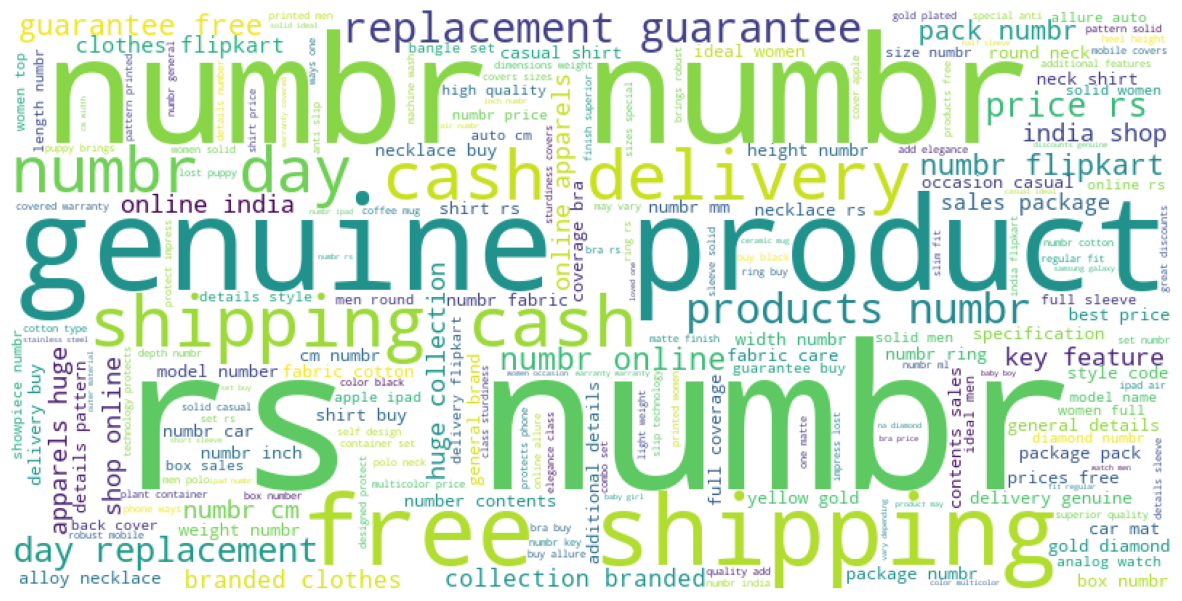

In [47]:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [48]:
specific_stop_words = ["numbr", "rs","flipkart","buy","com","free","day","cash","replacement","guarantee","genuine","key","feature","delivery","products","product","shipping", "online","india","shop"]
prod_cat_data['description'] = prod_cat_data['description'].apply(lambda a:" ".join(a for a in a.split() if a not in specific_stop_words))

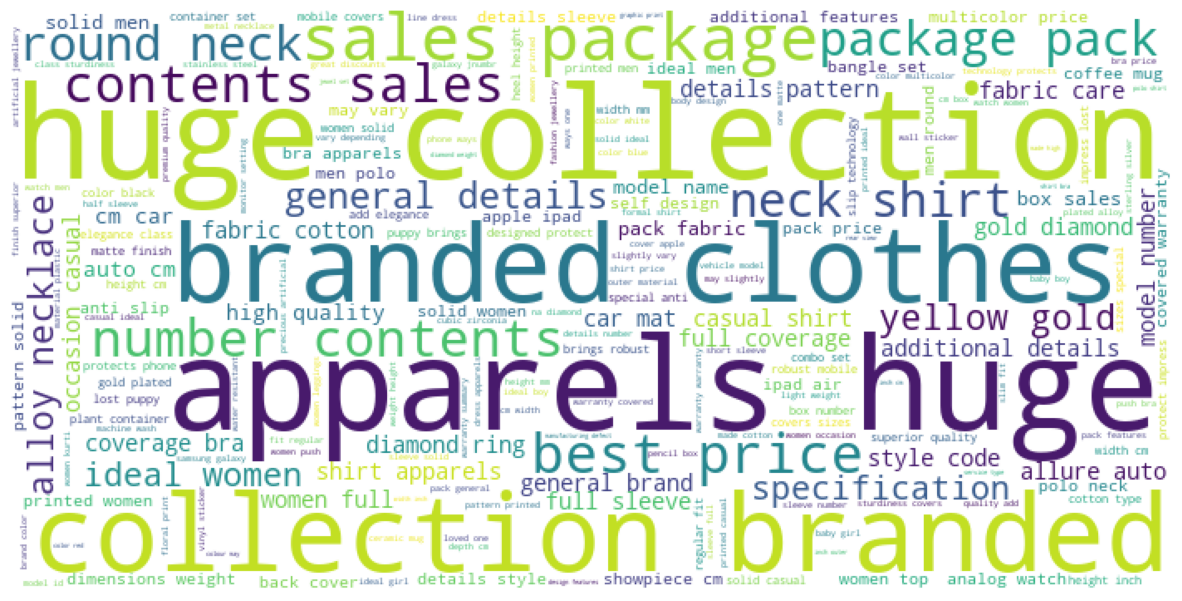

In [51]:
wordcloud = WordCloud(background_color="white", width = 700, height = 350).generate(' '.join(prod_cat_data['description']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [54]:

prod_tok = Tokenizer()
prod_tok.fit_on_texts(prod_cat_data['description'])
clean_description = prod_tok.texts_to_sequences(prod_cat_data['description'])
#padding
X = pad_sequences( clean_description, maxlen= 200)

In [56]:
from sklearn.preprocessing import LabelEncoder
num_class = len(np.unique(prod_cat_data.product_category_tree.values))
y = prod_cat_data['product_category_tree'].values
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [58]:
from sklearn.model_selection import train_test_split
indepentent_features_build, indepentent_features_valid, depentent_feature_build, depentent_feature_valid = train_test_split(X, y, test_size=0.2, random_state=1) 
print(indepentent_features_build.shape)
print(indepentent_features_valid.shape)
print(depentent_feature_build.shape)
print(depentent_feature_valid.shape)

(15998, 200)
(4000, 200)
(15998,)
(4000,)


In [74]:
MAX_LENGTH = 200
model_inp = Input(shape=(MAX_LENGTH, ))
object_layer = Embedding(16553,100,input_length=MAX_LENGTH)(model_inp)
a = Flatten()(object_layer)
a = Dense(30)(a)

model_pred = Dense(num_class, activation='softmax')(a)
output = Model(inputs=[model_inp], outputs=model_pred)

In [75]:
output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
output.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 100)          1655300   
                                                                 
 flatten_3 (Flatten)         (None, 20000)             0         
                                                                 
 dense_8 (Dense)             (None, 30)                600030    
                                                                 
 dense_9 (Dense)             (None, 6466)              200446    
                                                                 
Total params: 2455776 (9.37 MB)
Trainable params: 2455776 (9.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
filepath=""
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

out = output.fit([indepentent_features_build], batch_size=64,y=to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=5, callbacks=[x])

output_pred = output.predict(indepentent_features_valid)
output_pred = np.argmax(output_pred, axis=1)
accuracy_score(depentent_feature_valid, output_pred)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'model_4/embedding_4/embedding_lookup' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Derya\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Derya\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Derya\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Derya\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\Derya\anaconda3\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Derya\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\Derya\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Derya\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Derya\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Derya\AppData\Local\Temp\ipykernel_23320\2519177132.py", line 4, in <module>
      out = output.fit([indepentent_features_build], batch_size=64,y=to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=5, callbacks=[x])
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Derya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model_4/embedding_4/embedding_lookup'
indices[63,197] = 18602 is not in [0, 16553)
	 [[{{node model_4/embedding_4/embedding_lookup}}]] [Op:__inference_train_function_2372]

In [ ]:
model_inp = Input(shape=(MAX_LENGTH, ))

object_layer = Embedding(16553,100,input_length=MAX_LENGTH)(model_inp)
#convolutional layer
a = Conv1D(60, 10)(object_layer)
#add pooling layer
a = MaxPooling1D(pool_size=2)(a)
#add LSTM
a = LSTM(60)(a)
a = Dense(30)(a)
#final layer
model_pred = Dense(num_class, activation='softmax')(a)
output = Model(inputs=[model_inp], outputs=model_pred)
#compile
output.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
output.summary()


In [77]:
def build(num_filters, kernel_size, vocab_size, embedding_dim, maxlength):
    output = Sequential()
 #add embeddings
    output.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlength))
    output.add(layers.Conv1D(num_filters, kernel_size)) 
    output.add(layers.GlobalMaxPooling1D())
    output.add(layers.Dense(20))

    output.add(layers.Dense(num_class, activation='softmax'))
    output.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    return output

In [79]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
#build the models with parameters
output = KerasClassifier(build_fn=build, epochs=5, batch_size=64,verbose=False)
out = RandomizedSearchCV(estimator=output, param_distributions={'num_filters': [30, 60, 100],'kernel_size': [4, 6, 8],
'embedding_dim': [40],'vocab_size': [17862], 'maxlength': [180]},cv=4, verbose=1, n_iter=5)
out_result = out.fit(indepentent_features_build, depentent_feature_build)

In [ ]:
test_accuracy = out.score(indepentent_features_valid, depentent_feature_valid)
print(out_result.best_params_)
print(out_result.best_score_)